In [189]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from skopt.sampler import Halton

# Import GP interpolation module
from GEGP import GEGP

%matplotlib inline

ModuleNotFoundError: No module named 'skopt'

# 1. 1D Function Testing

## Nominal value predictions

In [43]:
X_train=np.array([0,0.1, 0.2,0.4,0.6,0.8, 1]).reshape(-1,1)
y_train =((6*X_train-2)**2)*np.sin(12*X_train-4)
grad_train = 12*(6*X_train-2)*np.sin(12*X_train-4) + \
    ((6*X_train-2)**2)*np.cos(12*X_train-4)*12

In [44]:
GEGP = GEGP()

In [45]:
GEGP.fit(X_train, y_train, grad_train)

In [46]:
X_test = np.linspace(0, 1, 100).reshape(-1,1)
y_test = ((6*X_test-2)**2)*np.sin(12*X_test-4)
grad_test = 12*(6*X_test-2)*np.sin(12*X_test-4) + \
    ((6*X_test-2)**2)*np.cos(12*X_test-4)*12

In [47]:
y_pred, y_pred_SSqr = GEGP.predict(X_test)

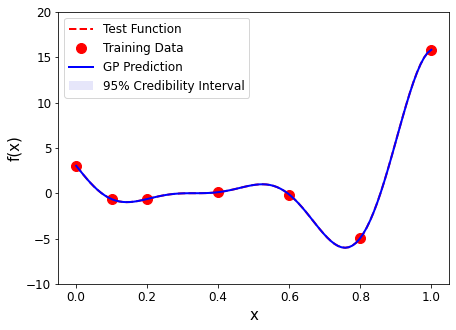

In [48]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

## Gradient predictions 

In [49]:
grad_cal = GEGP.predict_grad(X_test)

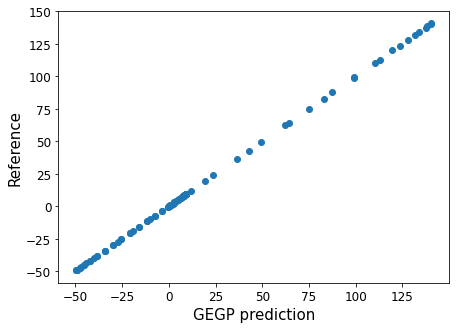

In [50]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(grad_cal.flatten(), grad_test.flatten(),'o')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('GEGP prediction', fontsize=15)
ax.set_ylabel('Reference', fontsize=15);

# 2. 2D Test Function 

## Nominal value predictions

In [150]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,[0]])**2 + 100*(X[:,[1]]-X[:,[0]]**2)**2
    
    grad = np.zeros_like(X)
    grad[:,[0]] = 2*(X[:,[0]]-1) - 400*(X[:,[1]]-X[:,[0]]**2)*X[:,[0]]
    grad[:,[1]] = 200*(X[:,[1]]-X[:,[0]]**2)
    
    return y, grad

In [151]:
def scale_grad(grad, lb, ub, inverse=False):
    """Scale the gradients"""
    if inverse is False:
        # Forward scaling: Converting to [0,1] scale 
        scaled_grad = grad*(ub-lb)     
    else:
        # Inverse scaling: Converting back to original scale 
        scaled_grad = grad/(ub-lb) 
        
    return scaled_grad

In [183]:
# Training data
sample_num = 25
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train, grad_train = Test_2D(X_train)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test, grad_test = Test_2D(X_test)

In [184]:
# Normalize training data
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
grad_train_std = scale_grad(grad_train, lb, ub, inverse=False)

In [185]:
# Fit a GEGP model
GEGP_2D = GEGP(n_restarts=20)
GEGP_2D.fit(X_train_std, y_train, grad_train_std.reshape((-1,1), order='F'))

In [186]:
# GEGP predictions
y_pred, y_pred_SSqr = GEGP_2D.predict(scaler.transform(X_test))

# Gradient predictions
grad_cal = GEGP_2D.predict_grad(scaler.transform(X_test))

# Scale the gradients back to original scale
grad_cal = scale_grad(grad_cal, lb, ub, inverse=True)

Text(0, 0.5, 'Reference')

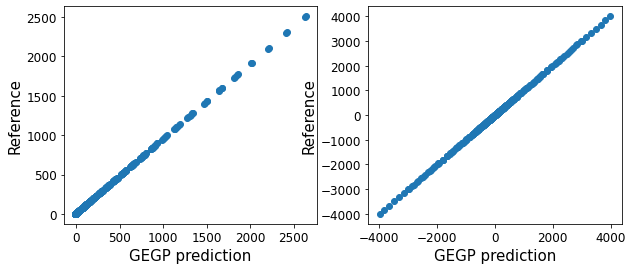

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Check nominal predictions
ax[0].plot(y_pred, y_test.flatten(),'o')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('GEGP prediction', fontsize=15)
ax[0].set_ylabel('Reference', fontsize=15)

# Check gradient calculations
ax[1].plot(grad_cal[:,0], grad_test[:,0],'o')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('GEGP prediction', fontsize=15)
ax[1].set_ylabel('Reference', fontsize=15)

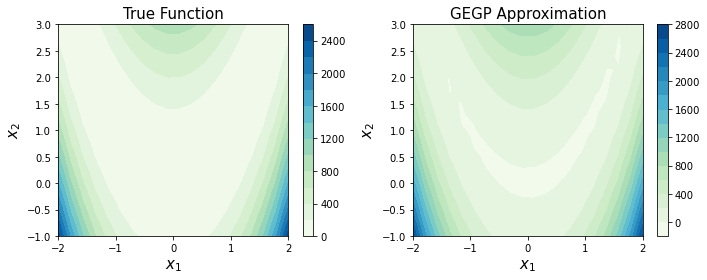

In [188]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GEGP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()